In [1]:
## Intro to the problem that is being addressed.
## Looking at residential home prices paid data from UK Data
## Predicting home price paid

In [2]:
## Import the relevant python packages

## Core packages for data wrangling, analysis, and charting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import datetime
from collections import Counter
import json
from pandas.io.json import json_normalize

## Mapping packages for presentation and geocoding
import folium
from folium.plugins import HeatMap
import geopandas
import gmaps #Google Maps python package
import branca
import geopy
from geopy.geocoders import Nominatim

## Statistics and machine learning packages
import scipy.stats as stats
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import locale

%matplotlib inline

In [68]:
## Introduce the dataset and provide a url

## import the whole dataset for 2018
## Data does not have column headers, so we set these up to add custom column names
column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking (importing it in pieces) as it is a large file
df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

In [69]:
df.head()

,transaction_ID,price,transfer_date,postcode,property_type,new_build,duration,PAON,SAON,street,locality,town_city,district,county,PPD_category_type,record_status
0,{79A74E21-D11E-1289-E053-6B04A8C01627},770000,2018-09-25 00:00,SK7 1AR,D,N,F,5,NaN,OAK MEADOW,BRAMHALL,STOCKPORT,STOCKPORT,GREATER MANCHESTER,A,A
1,{79A74E21-D11F-1289-E053-6B04A8C01627},253500,2018-09-24 00:00,M6 8GQ,D,N,F,1,NaN,RIVINGTON ROAD,NaN,SALFORD,SALFORD,GREATER MANCHESTER,A,A
2,{79A74E21-D120-1289-E053-6B04A8C01627},231950,2018-09-28 00:00,WA3 2UE,D,Y,F,35,NaN,STONEACRE CLOSE,LOWTON,WARRINGTON,WIGAN,GREATER MANCHESTER,A,A
3,{79A74E21-D121-1289-E053-6B04A8C01627},112500,2018-08-29 00:00,OL6 6RJ,S,N,F,102,NaN,THORNFIELD GROVE,NaN,ASHTON-UNDER-LYNE,TAMESIDE,GREATER MANCHESTER,A,A
4,{79A74E21-D122-1289-E053-6B04A8C01627},184995,2018-06-15 00:00,M46 0TW,S,Y,F,37,NaN,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,A,A


In [70]:
## Filter down to London only
df = df[df['town_city'] == 'LONDON']
len(df)

66191

In [71]:
## We will create a couple new columns, which will help in our later analysis.
## These will be a trimmed postcode that correlates to postcode areas, as well as 
## month and year separated out from date column.

## Trim the postcode column down to the first set of characters (removing last 3)
df['postcode_area'] = [str(x)[:-4] for x in df.postcode]

## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

In [72]:
prop_type_dict = {'D': 'Detached',
                 'S': 'Semi-detached',
                 'F': 'Flat',
                 'T': 'Terraced',
                 'O': 'Other'}

new_build_dict = {'N': 'Old',
                 'Y': 'New'}

duration_dict = {'F': 'Freehold',
                 'L': 'Leasehold'}

We also add a conditional to this conversion so that if this notebook is run multiple times we won't get an error.

In [73]:
## Change the property type for more readability
if len(df['property_type'].iloc[0]) == 1:
    df['property_type'] = df['property_type'].map(prop_type_dict)

In [74]:
## Change the build type for more readability
if len(df['new_build'].iloc[0]) == 1:
    df['new_build'] = df['new_build'].map(new_build_dict)

In [75]:
## Change the Duration attribute for more readability
if len(df['duration'].iloc[0]) == 1:
    df['duration'] = df['duration'].map(duration_dict)

In [76]:
df.head()

,transaction_ID,price,transfer_date,postcode,property_type,new_build,duration,PAON,SAON,street,locality,town_city,district,county,PPD_category_type,record_status,postcode_area,month,year
1032,{7011B109-D879-8ED6-E053-6B04A8C075C1},1205000,2018-05-25,SW13 0NZ,Terraced,Old,Freehold,6,NaN,CHARLES STREET,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW13,5,2018
1037,{7011B109-D87E-8ED6-E053-6B04A8C075C1},5200000,2018-06-04,SW19 7BW,Detached,Old,Freehold,8,NaN,ST MARYS ROAD,NaN,LONDON,MERTON,GREATER LONDON,A,A,SW19,6,2018
1046,{7011B109-D888-8ED6-E053-6B04A8C075C1},616000,2018-05-17,SW13 0PN,Terraced,Old,Freehold,51,NaN,RAILWAY SIDE,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW13,5,2018
1059,{7011B109-D895-8ED6-E053-6B04A8C075C1},620000,2018-05-30,SW14 8EZ,Terraced,Old,Freehold,22,NaN,MULLINS PATH,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW14,5,2018
1340,{666758D7-3BE8-3363-E053-6B04A8C0D74E},211500,2018-01-31,SE20 8DN,Flat,Old,Leasehold,55,NaN,ORCHARD GROVE,NaN,LONDON,BROMLEY,GREATER LONDON,A,A,SE20,1,2018


#### Add in the population density information to create a scatter plot of prices to density
#### Data source: Nomis UK population database of all postcode areas and population density from
#### 2011 - ONS Crown Copyright Reserved [from Nomis on 24 October 2019]
pop_density = pd.read_csv('UK_pop_density_postcodes.csv')[8:]
density_columns = ['long_code', 'postcode_area', 'population_density']
pop_density.columns = density_columns
pop_density = pop_density.drop(columns='long_code')
pop_density.head(10)

In [ ]:
## Add the population density data to the prices paid dataset by merging the tables
## Used an if-statement to prevent multiple merges.
if 'population_density' not in df.columns:
    df = df.merge(pop_density, how='left', on='postcode_area')

df[df['postcode_area'] == 'N4'].head()

In [18]:
## Add additional datasets that will be used - London boroughs and London wards

wards = geopandas.read_file('/Users/user/Desktop/Datasets/London_Wards.geojson')
#wards = f'/Users/user/Desktop/Datasets/London_Wards.json'
#boroughs = geopandas.read_file(boroughs, SHAPE_RESTORE_SHX='yes')
wards['geometry'].head()

0    POLYGON ((517175.296 164077.303, 517177.300 16...
1    POLYGON ((519552.998 164295.600, 519508.096 16...
2    POLYGON ((518107.499 167303.399, 518114.301 16...
3    POLYGON ((520336.700 165105.498, 520332.198 16...
4    POLYGON ((521201.203 169275.505, 521204.303 16...
Name: geometry, dtype: geometry

In [21]:
london_centre = [51.5074, -0.1278]
london_map = folium.Map(location=london_centre, 
                        zoom_start=10)

#folium.GeoJson(wards, name='London Wards').add_to(london_map)

In [22]:
london_map

In [12]:
london_map.save('London Wards.html')

In [122]:
credentials = pd.read_csv('/Users/user/Desktop/Datasets/credentials.csv')
google_api = credentials.iloc[0,1]

In [143]:
## geotag the London data using Google's Geocoding service

API_KEY = google_api
#url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address, API_KEY)
coordinates = []


for x in range(100):
    address = str(df.iloc[x]['PAON']) + ', ' + \
          str(df.iloc[x]['street']) + ', ' + \
          str(df.iloc[x]['town_city']) + ', ' + \
          str(df.iloc[x]['district'])
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address, API_KEY)
    r = requests.get(url)
    lat_lng = [r.json()['results'][0]['geometry']['location']['lat'],
                             r.json()['results'][0]['geometry']['location']['lng']]
    coordinates.append(lat_lng)

In [144]:
london_centre = [51.5074, -0.1278]
homes_map = folium.Map(location=london_centre, 
                        zoom_start=10,
                       tiles='cartodbpositron',
                       attr='CartoDB')

folium.Layer()

for x in range(len(coordinates)):
    marker = folium.Marker(location=coordinates[x])
    marker.add_to(homes_map)

In [149]:
HeatMap(coordinates, name='Heatmap').add_to(homes_map)

folium.LayerControl().add_to(homes_map)

homes_map

In [16]:
## Map the London dataset

## Add the polygon boroughs and wards as optional layers
## Add a heatmap of the properties as optional layer

In [21]:
## Create a function that adds the number of nearby sales as an additional attribute to the homes dataset
## for x in len(range(dataset)):
#        geopandas.overlay(how='intersection')
    
from shapely.geometry import Polygon

polys1 = geopandas.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                               Polygon([(2,2), (4,2), (4,4), (2,4)])])

polys2 = geopandas.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                               Polygon([(3,3), (5,3), (5,5), (3,5)])])

df1 = geopandas.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = geopandas.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

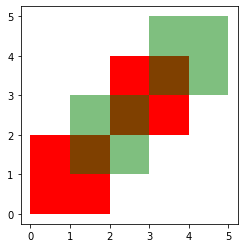

In [23]:
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5);

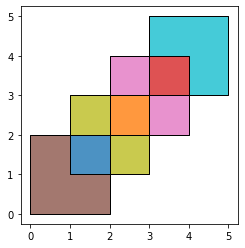

In [34]:
res_union = geopandas.overlay(df1, df2, how='union') # or intersection, symmetric_difference, difference
ax = res_union.plot(alpha=0.8, cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

### For predictive modelling, first we will preprocess the data to ensure it can by properly read by the scikit-learn packge. This involves converting ordinal (categorical) data into numerical data.

In [110]:
## Create a new dataframe using the function created above to capture the attributes
## to use in the prediction

attributes = ['property_type', 'new_build', 'district']
df_attr = df[attributes]
df_attr.head()

,property_type,new_build,district
1032,Terraced,Old,RICHMOND UPON THAMES
1037,Detached,Old,MERTON
1046,Terraced,Old,RICHMOND UPON THAMES
1059,Terraced,Old,RICHMOND UPON THAMES
1340,Flat,Old,BROMLEY


In [ ]:
enc = OneHotEncoder(sparse=False)

x_encoded = enc.fit_transform(df_attr)

x_encoded = pd.DataFrame(x_encoded)

x_encoded

In [ ]:
data_ohe = OneHotEncoder().fit_transform(data).toarray()
z = pd.DataFrame(data_ohe)

z.columns = cols
z['price'] = df_ten.price.reset_index().price
z.head()

In [ ]:
build_type = df_ten['new_build']
prop_type = df_ten['property_type']
cityID = df_ten['town_city']

xencode = LabelEncoder()
build_type = xencode.fit_transform(build_type)
xkeys = xencode.classes_
xkeys = list(xkeys)

yencode = LabelEncoder()
prop_type = yencode.fit_transform(prop_type)
ykeys = yencode.classes_
ykeys = list(ykeys)

zencode = LabelEncoder()
cityID = zencode.fit_transform(cityID)
zkeys = zencode.classes_
zkeys = list(zkeys)

cols = xkeys + ykeys + zkeys
cols

In [ ]:
build_type = pd.DataFrame(build_type)
prop_type = pd.DataFrame(prop_type)
cityID = pd.DataFrame(cityID)

data = pd.concat([build_type, prop_type, cityID], axis=1)
data

### Assign the data to the scikit-learn packages, starting with Decision Trees

In [ ]:
locale.setlocale(locale.LC_ALL, "")

feature_cols = cols

X = z[feature_cols] #features
y = z.price #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Create Decision Tree classifer object
reg = DecisionTreeRegressor()

# Train Decision Tree Classifer
model = reg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [ ]:
y_train_pred = model.predict(X_train)

np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

In [ ]:


np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
rand = np.random.uniform(low=0, high=len(df_ten))

X_new = df_ten.iloc[int(rand)]

# Model Accuracy, how often is the regressor correct?
print("City X: %s" % X_new.loc['town_city'])
print('X: £{:,.2f}, Predicted: £{:,.2f}'.format(X_new[0], y_pred[X_new[0]]))
print('Difference (£): {:+,.0f}'.format(X_new[0] - y_pred[0]))
print('Difference Predicted (%): {:+.2f}%'.format(((y_pred[0] - X_new[0]) / X_new[0]) * 100))